# Problem set 3: DQN, Policy gradient and its variants

**Due: 11:59pm, November 2, 2025**

In the last PSET of reinforcement learning, you will implement the DQN algorithm together with vanilla policy gradient (REINFORCE) and its variants. In the last problem you will train a half-cheetah with stable baseline 3 package. 

- Problem 1 requires implementing DQN and double DQN. **TODOs:**
  
  - 1.1 Finish vanilla DQN (20 pt)
  - 1.2 Finish double DQN (5 pt)

- Problem 2 verify the policy gradient theory and requires implementing REINFORCE with learned value function. **TODOs:**
  
  - 2.1 Verify different policy gradient estimator (15 pt)
  - 2.2 Implement REINFORCE with learned baseline (10 pt)

- Problem 3 requires implementing vanilla on-policy actor-critic algorithm. **TODOs:**
  - 3.1 Implement vanilla actor-critic (25 pt)

All of these three algorithms works on `gym`'s `Acrobot-v1` environments.

- Problem 4 requires implementing PPO algorithm. **TODOs:**
  - 4.1 Implement PPO-cliping (25 pt)

- Problem 5 **(Bonus)** help you try stable baseline 3 on `gym`'s `Half-cheetah-v4` environment. **TODOs:**
  - 5.1 Tune the parameter in stable baseline 3 (**Note the training can take 15 min**) (20 pt)
  

## Problem 1: DQN

In this problem you will implement DQN on `Acrobot-v1` environment using `gym`.

### Algorithm recap

1. **Q-network**
   - Function approximator $Q_\theta(s,a)$ for action values (here: a small MLP).

2. **Target network**
   - A copy of the online network with parameters $\theta^-$ that are updates periodically to stabilize training.

3. **Experience replay**
   - A replay buffer of transitions $(s,a,r,s',\text{done})$. Sample i.i.d. minibatches to break temporal correlations.

4. **Behavior policy**
   - $\epsilon$-greedy: with probability $\epsilon$ choose a random action; otherwise choose $ \arg\max_a Q_\theta(s,a) $.

5. **TD targets**
   - **Standard DQN**:
     $$
     y = r + \gamma \max_{a'} Q_{\theta^-}(s', a')
     $$
   - **Double DQN**:
     $$
     a^\star = \arg\max_{a'} Q_{\theta}(s', a'), \quad
     y = r + \gamma \, Q_{\theta^-}(s', a^\star)
     $$
     “Online net selects, target net evaluates” reduces overestimation. In comparison to Double Q-learning, the weights of the second network $\theta$ are replaced with the weights of the target network $\theta^−$ for the evaluation of the current greedy policy. The update to the target network stays unchanged from DQN, and remains a periodic copy of the online network.

6. **Loss & optimization**
   - Regress $Q_\theta(s,a)$ to target $y$ using MSE loss; backpropagate to update $\theta$.

### Environment & action space

- **Env**: `Acrobot-v1` (double pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/acrobot/)
- **Observation**: 6D —- $\cos\theta_1, \sin\theta_1, \cos\theta_2, \sin\theta_2, \dot\theta_1, \dot\theta_2$  
- **Actions**: Discrete 3 actions —- torques $-1, 0, +1$  
- **Reward**: $-1$ per step until the goal is reached (or the episode times out)


### 1.1 Implement DQN with gym

**TODO:** Fill in the three TODO blocks.
- implement a simple MLP
- implement the replaybuffer class
- implement the main algorithm

All the given code is for reference. If you find it inconvenient feel free to write yourself.

Note the final average return should be around $-100$.

[Env] Acrobot-v1 | obs_dim=6, n_actions=3
[Ep   10] avg_return(10)=-500.00 eps=0.905 buffer=5000 last_loss=45.3044
[Ep   20] avg_return(10)=-498.50 eps=0.810 buffer=9986 last_loss=10.6543
[Ep   30] avg_return(10)=-416.40 eps=0.731 buffer=14158 last_loss=1.0979
[Ep   40] avg_return(10)=-378.90 eps=0.659 buffer=17956 last_loss=62.2863
[Ep   50] avg_return(10)=-337.90 eps=0.595 buffer=21343 last_loss=4.1670
[Ep   60] avg_return(10)=-216.20 eps=0.553 buffer=23515 last_loss=9.2039
[Ep   70] avg_return(10)=-207.00 eps=0.514 buffer=25595 last_loss=11.4959
[Ep   80] avg_return(10)=-211.70 eps=0.473 buffer=27722 last_loss=3.0625
[Ep   90] avg_return(10)=-139.40 eps=0.447 buffer=29126 last_loss=2.8578
[Ep  100] avg_return(10)=-147.80 eps=0.418 buffer=30614 last_loss=4.2341
[Ep  110] avg_return(10)=-179.50 eps=0.384 buffer=32418 last_loss=11.0623
[Ep  120] avg_return(10)=-137.80 eps=0.358 buffer=33806 last_loss=5.3565
[Ep  130] avg_return(10)=-144.10 eps=0.330 buffer=35257 last_loss=1.3107
[Ep  1

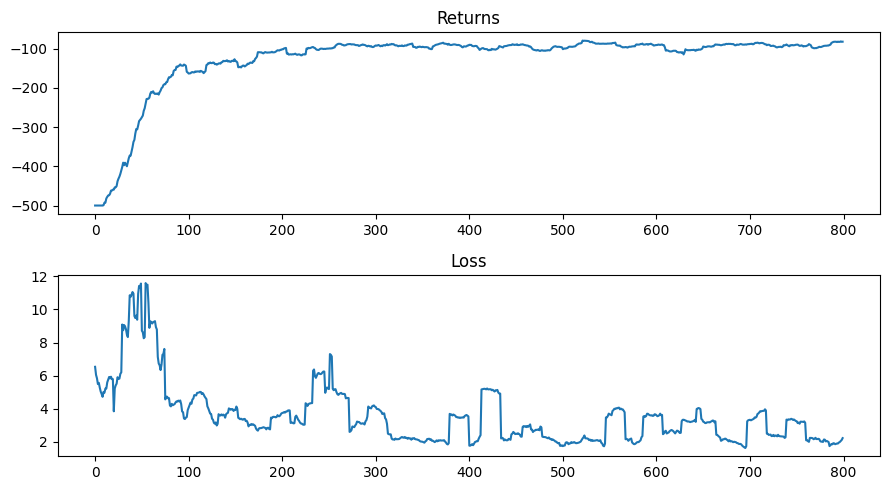

In [4]:

import os, random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy

# ------------------- config  -------------------
ENV_ID                 = "Acrobot-v1"
SEED                   = 42
GAMMA                  = 0.995
LR                     = 1e-3
BATCH_SIZE             = 64
BUFFER_SIZE            = 100_000
START_TRAINING_AFTER   = 1000       # warmup steps
TARGET_UPDATE_FREQ     = 10       # steps (hard update)
MAX_EPISODES           = 800

GRAD_CLIP_NORM         = 10.0
PRINT_EVERY_EPISODES   = 10

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

state_dims = int(np.prod(env.observation_space.shape))  # Acrobot: 6
num_actions = env.action_space.n                        # Acrobot: 3
print(f"[Env] {ENV_ID} | obs_dim={state_dims}, n_actions={num_actions}")

# ------------------- gym environment -> tensor -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info

env = TWrapper(env)

# ------------------- Q network -------------------
class QNetwork(nn.Module):
    #########################################
    #TODO 1.1: Implement a simple MLP

    def __init__(self, in_dim: int, n_actions: int, hidden_sizes=(128, 128)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], n_actions),
        )

        # Kaiming init for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, state_dim)
        return self.net(x)
    #########################################
   

q_net = QNetwork(state_dims, num_actions)
tgt_net = copy.deepcopy(q_net).eval()

# ------------------- simple replay buffer -------------------
class ReplayBuffer:
    def __init__(self, capacity=BUFFER_SIZE):
        self.capacity, self.mem, self.pos = capacity, [], 0
    #########################################
    #TODO 1.1: Implement a ReplayBuffer
    # capacity: max number of transitions to store
    # mem: list of transitions
    # pos: next position to insert
    # push: add a transition
    # sample: random sample a batch of transitions

    def push(self, s, a, r, ns, d):
        # store tensors (1,dim) etc.; detach to be safe
        transition = (s.detach(), a.detach(), r.detach(), ns.detach(), d.detach())
        if len(self.mem) < self.capacity:
            self.mem.append(transition)
        else:
            self.mem[self.pos] = transition
        self.pos = (self.pos + 1) % self.capacity

    def __len__(self):
        return len(self.mem)

    def sample(self, batch_size: int):
        batch = random.sample(self.mem, batch_size)
        s, a, r, ns, d = zip(*batch)
        # cat along batch dimension
        states      = torch.cat(s, dim=0)   # (B, state_dim)
        actions     = torch.cat(a, dim=0)   # (B, 1) long
        rewards     = torch.cat(r, dim=0)   # (B, 1) float
        next_states = torch.cat(ns, dim=0)  # (B, state_dim)
        dones       = torch.cat(d, dim=0)   # (B, 1) bool
        return states, actions, rewards, next_states, dones
    #########################################
    
buffer = ReplayBuffer()
optim  = Adam(q_net.parameters(), lr=LR)

# ------------------- greedy / epsilon-greedy -------------------
@torch.no_grad()
def act_epsilon_greedy(state: torch.Tensor, eps: float) -> torch.Tensor:
    if torch.rand(1).item() < eps:
        return torch.randint(num_actions, (1, 1))
    q = q_net(state)
    return torch.argmax(q, dim=-1, keepdim=True)

# ------------------- train loop (Double DQN target) -------------------
def train():
    returns_hist, loss_hist = [], []

    global_step = 0
    eps_start, eps_end = 1.0, 0.05
    eps_decay_steps = 50_000  # linear decay over these many env steps

    for ep in range(1, MAX_EPISODES + 1):
        #########################################
        #TODO 1.1: Implement the main algorithm here

        state, _ = env.reset()
        ep_return = 0.0
        done = False
        last_loss = None

        while not done:
            # epsilon schedule
            eps = max(eps_end, eps_start - (eps_start - eps_end) * (global_step / eps_decay_steps))

            # act
            action = act_epsilon_greedy(state, eps)  # (1,1) long
            next_state, reward, done_t, _ = env.step(action)
            done = bool(done_t.item())
            ep_return += float(reward.item())

            # store
            buffer.push(state, action, reward, next_state, done_t)
            state = next_state
            global_step += 1

            # learn
            if len(buffer) >= max(BATCH_SIZE, START_TRAINING_AFTER):
                s, a, r, ns, d = buffer.sample(BATCH_SIZE)

                # current Q(s,a)
                q_values = q_net(s).gather(1, a)  # (B,1)

        #########################################
        #########################################
        #TODO 1.2: Change from DQN to Double DQN

                with torch.no_grad():

                    # ---- Vanilla DQN target ----
                    next_q = tgt_net(ns).max(dim=1, keepdim=True).values
                    target = r + (1.0 - d.float()) * GAMMA * next_q

                    # # Double DQN:
                    # # a* = argmax_a Q_online(ns, a)
                    # next_actions = torch.argmax(q_net(ns), dim=1, keepdim=True)  # (B,1)
                    # # target uses tgt_net but selects Q by next_actions from online
                    # next_q = tgt_net(ns).gather(1, next_actions)  # (B,1)
                    # target = r + (1.0 - d.float()) * GAMMA * next_q


                loss = F.mse_loss(q_values, target)

                optim.zero_grad(set_to_none=True)
                loss.backward()
                nn.utils.clip_grad_norm_(q_net.parameters(), GRAD_CLIP_NORM)
                optim.step()

                last_loss = float(loss.item())

                # hard target update
                if global_step % TARGET_UPDATE_FREQ == 0:
                    tgt_net.load_state_dict(q_net.state_dict())

        returns_hist.append(ep_return)
        loss_hist.append(0.0 if last_loss is None else last_loss)

        if ep % PRINT_EVERY_EPISODES == 0:
            avg_ret = np.mean(returns_hist[-PRINT_EVERY_EPISODES:])
            print(f"[Ep {ep:4d}] avg_return({PRINT_EVERY_EPISODES})={avg_ret:7.2f} "
                  f"eps={eps:5.3f} buffer={len(buffer)} last_loss={loss_hist[-1]:.4f}")

        #########################################
        
    plot_stats({"Returns": returns_hist, "Loss": loss_hist})

# ------------------- plotting -------------------
def _smooth(x, w=21):
    if len(x) < w: return x
    k = w // 2
    return [np.mean(x[max(0, i-k):min(len(x), i+k+1)]) for i in range(len(x))]

def plot_stats(stats: dict, win: int = 21):
    fig, axs = plt.subplots(len(stats), 1, figsize=(9, 5), tight_layout=True)
    if len(stats) == 1: axs = [axs]
    for ax, (k, v) in zip(axs, stats.items()):
        ax.plot(_smooth(v, win))
        ax.set_title(k)
    plt.show()
    plt.close()

train()
env.close()


### 1.2 Change classical DQN to double DQN

Use **two networks**:
- **Online** network selects the next action  
  $$
  a^* = \arg\max_{a'} Q_{\text{online}}(s', a').
  $$
- **Target** network evaluates that action  
  $$
  y_{\text{DDQN}} = r + \gamma\, Q_{\text{target}}(s', a^*).
  $$
  
This decoupling reduces overestimation while keeping the update otherwise unchanged.

In the code you will only need to change several lines. 

**TODO:** Comment the vanilla DQN and write Double DQN at the same place.

[Env] Acrobot-v1 | obs_dim=6, n_actions=3
[Ep   10] avg_return(10)=-500.00 eps=0.905 buffer=5000 last_loss=26.4400
[Ep   20] avg_return(10)=-465.60 eps=0.816 buffer=9660 last_loss=7.7273
[Ep   30] avg_return(10)=-407.10 eps=0.739 buffer=13738 last_loss=3.4195
[Ep   40] avg_return(10)=-372.50 eps=0.668 buffer=17471 last_loss=6.9137
[Ep   50] avg_return(10)=-291.80 eps=0.612 buffer=20399 last_loss=6.3368
[Ep   60] avg_return(10)=-261.20 eps=0.563 buffer=23021 last_loss=6.7013
[Ep   70] avg_return(10)=-193.60 eps=0.526 buffer=24967 last_loss=3.3064
[Ep   80] avg_return(10)=-202.40 eps=0.487 buffer=27001 last_loss=4.4344
[Ep   90] avg_return(10)=-197.80 eps=0.449 buffer=28989 last_loss=3.3018
[Ep  100] avg_return(10)=-158.90 eps=0.419 buffer=30588 last_loss=2.4290
[Ep  110] avg_return(10)=-135.10 eps=0.393 buffer=31949 last_loss=8.7288
[Ep  120] avg_return(10)=-158.20 eps=0.363 buffer=33541 last_loss=4.0870
[Ep  130] avg_return(10)=-135.70 eps=0.337 buffer=34908 last_loss=1.8282
[Ep  140] 

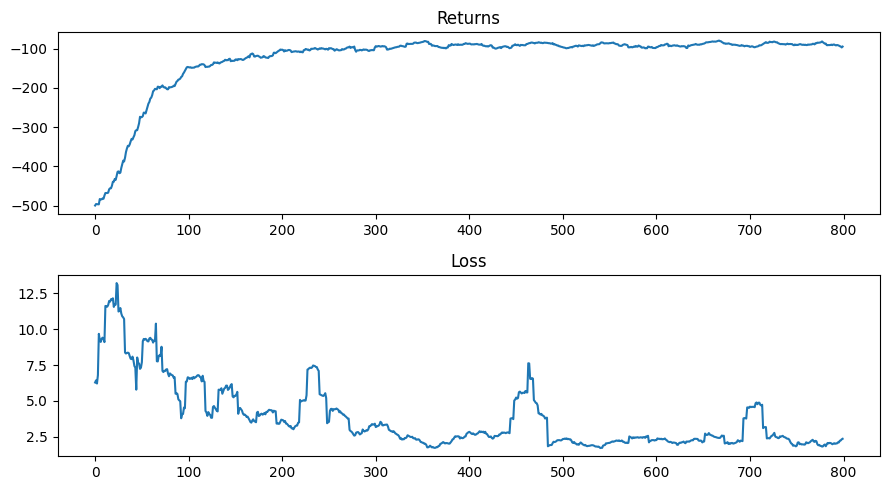

In [5]:

import os, random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy

# ------------------- config  -------------------
ENV_ID                 = "Acrobot-v1"
SEED                   = 42
GAMMA                  = 0.995
LR                     = 1e-3
BATCH_SIZE             = 64
BUFFER_SIZE            = 100_000
START_TRAINING_AFTER   = 1000       # warmup steps
TARGET_UPDATE_FREQ     = 10       # steps (hard update)
MAX_EPISODES           = 800

GRAD_CLIP_NORM         = 10.0
PRINT_EVERY_EPISODES   = 10

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

state_dims = int(np.prod(env.observation_space.shape))  # Acrobot: 6
num_actions = env.action_space.n                        # Acrobot: 3
print(f"[Env] {ENV_ID} | obs_dim={state_dims}, n_actions={num_actions}")

# ------------------- gym environment -> tensor -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info

env = TWrapper(env)

# ------------------- Q network -------------------
class QNetwork(nn.Module):
    #########################################
    #TODO 1.1: Implement a simple MLP

    def __init__(self, in_dim: int, n_actions: int, hidden_sizes=(128, 128)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], n_actions),
        )

        # Kaiming init for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, state_dim)
        return self.net(x)
    #########################################
   

q_net = QNetwork(state_dims, num_actions)
tgt_net = copy.deepcopy(q_net).eval()

# ------------------- simple replay buffer -------------------
class ReplayBuffer:
    def __init__(self, capacity=BUFFER_SIZE):
        self.capacity, self.mem, self.pos = capacity, [], 0
    #########################################
    #TODO 1.1: Implement a ReplayBuffer
    # capacity: max number of transitions to store
    # mem: list of transitions
    # pos: next position to insert
    # push: add a transition
    # sample: random sample a batch of transitions

    def push(self, s, a, r, ns, d):
        # store tensors (1,dim) etc.; detach to be safe
        transition = (s.detach(), a.detach(), r.detach(), ns.detach(), d.detach())
        if len(self.mem) < self.capacity:
            self.mem.append(transition)
        else:
            self.mem[self.pos] = transition
        self.pos = (self.pos + 1) % self.capacity

    def __len__(self):
        return len(self.mem)

    def sample(self, batch_size: int):
        batch = random.sample(self.mem, batch_size)
        s, a, r, ns, d = zip(*batch)
        # cat along batch dimension
        states      = torch.cat(s, dim=0)   # (B, state_dim)
        actions     = torch.cat(a, dim=0)   # (B, 1) long
        rewards     = torch.cat(r, dim=0)   # (B, 1) float
        next_states = torch.cat(ns, dim=0)  # (B, state_dim)
        dones       = torch.cat(d, dim=0)   # (B, 1) bool
        return states, actions, rewards, next_states, dones
    #########################################
    
buffer = ReplayBuffer()
optim  = Adam(q_net.parameters(), lr=LR)

# ------------------- greedy / epsilon-greedy -------------------
@torch.no_grad()
def act_epsilon_greedy(state: torch.Tensor, eps: float) -> torch.Tensor:
    if torch.rand(1).item() < eps:
        return torch.randint(num_actions, (1, 1))
    q = q_net(state)
    return torch.argmax(q, dim=-1, keepdim=True)

# ------------------- train loop (Double DQN target) -------------------
def train():
    returns_hist, loss_hist = [], []

    global_step = 0
    eps_start, eps_end = 1.0, 0.05
    eps_decay_steps = 50_000  # linear decay over these many env steps

    for ep in range(1, MAX_EPISODES + 1):
        #########################################
        #TODO 1.1: Implement the main algorithm here

        state, _ = env.reset()
        ep_return = 0.0
        done = False
        last_loss = None

        while not done:
            # epsilon schedule
            eps = max(eps_end, eps_start - (eps_start - eps_end) * (global_step / eps_decay_steps))

            # act
            action = act_epsilon_greedy(state, eps)  # (1,1) long
            next_state, reward, done_t, _ = env.step(action)
            done = bool(done_t.item())
            ep_return += float(reward.item())

            # store
            buffer.push(state, action, reward, next_state, done_t)
            state = next_state
            global_step += 1

            # learn
            if len(buffer) >= max(BATCH_SIZE, START_TRAINING_AFTER):
                s, a, r, ns, d = buffer.sample(BATCH_SIZE)

                # current Q(s,a)
                q_values = q_net(s).gather(1, a)  # (B,1)

        #########################################
        #########################################
        #TODO 1.2: Change from DQN to Double DQN

                with torch.no_grad():

                    # # ---- Vanilla DQN target ----
                    # next_q = tgt_net(ns).max(dim=1, keepdim=True).values
                    # target = r + (1.0 - d.float()) * GAMMA * next_q

                    # Double DQN:
                    # a* = argmax_a Q_online(ns, a)
                    next_actions = torch.argmax(q_net(ns), dim=1, keepdim=True)  # (B,1)
                    # target uses tgt_net but selects Q by next_actions from online
                    next_q = tgt_net(ns).gather(1, next_actions)  # (B,1)
                    target = r + (1.0 - d.float()) * GAMMA * next_q


                loss = F.mse_loss(q_values, target)

                optim.zero_grad(set_to_none=True)
                loss.backward()
                nn.utils.clip_grad_norm_(q_net.parameters(), GRAD_CLIP_NORM)
                optim.step()

                last_loss = float(loss.item())

                # hard target update
                if global_step % TARGET_UPDATE_FREQ == 0:
                    tgt_net.load_state_dict(q_net.state_dict())

        returns_hist.append(ep_return)
        loss_hist.append(0.0 if last_loss is None else last_loss)

        if ep % PRINT_EVERY_EPISODES == 0:
            avg_ret = np.mean(returns_hist[-PRINT_EVERY_EPISODES:])
            print(f"[Ep {ep:4d}] avg_return({PRINT_EVERY_EPISODES})={avg_ret:7.2f} "
                  f"eps={eps:5.3f} buffer={len(buffer)} last_loss={loss_hist[-1]:.4f}")

        #########################################
        
    plot_stats({"Returns": returns_hist, "Loss": loss_hist})

# ------------------- plotting -------------------
def _smooth(x, w=21):
    if len(x) < w: return x
    k = w // 2
    return [np.mean(x[max(0, i-k):min(len(x), i+k+1)]) for i in range(len(x))]

def plot_stats(stats: dict, win: int = 21):
    fig, axs = plt.subplots(len(stats), 1, figsize=(9, 5), tight_layout=True)
    if len(stats) == 1: axs = [axs]
    for ax, (k, v) in zip(axs, stats.items()):
        ax.plot(_smooth(v, win))
        ax.set_title(k)
    plt.show()
    plt.close()

train()
env.close()


## Problem 2: Policy Gradient

<!-- #### reparameterization trick:

Let $x$ be a random variable whose distribution depends on $\theta$. Write this as $x\sim p_\theta(x)$. For any measurable $V:\mathcal X\to\mathbb R$,
$$
\mathbb{E}\big[V(f(\theta))\big] \;=\; \mathbb{E}_{x\sim p_\theta}[V(x)],
$$
where $p_\theta$ is the distribution of $x$ induced by $\theta$. This help us move complex functions from expectation to distribution.

Take the gradient gives us

$$
\nabla \mathbb{E}_{x\sim p_\theta}[V(x)] = \int \nabla p_\theta(x) V(x) dx = \int \nabla \ln(p_\theta(x)) V(x) p_\theta(x)dx = \mathbb{E}_{x\sim p_\theta}[V(x) \nabla \ln(p_\theta(x))]
$$

So now we only need to take derivative of the distribution.

### RL as an Expectation over Trajectories
The cost over a distribution of $s_0$ gives the definition of reward function $J$:

$$
\mathbb{E}_{s_0\sim\rho}[V^{\pi_\theta}(s_0)]
$$

But use the trick above we can rewrite that using trajectory. A trajectory is
$$
\tau=(s_0,a_0,s_1,a_1,\ldots,s_T),
$$
generated by initial state distribution $\rho$, policy $\pi_\theta(a\mid s)$, and dynamics $P(s'\mid s,a)$. The trajectory distribution is
$$
p_\theta(\tau)=\rho(s_0)\prod_{t=0}^{T-1}\pi_\theta(a_t\mid s_t)\,P(s_{t+1}\mid s_t,a_t).
$$
Define the discounted return
$$
G(\tau)=\sum_{t=0}^{T-1}\gamma^t\,r(s_t,a_t).
$$
Then the performance objective is
$$
\,J(\theta)=\mathbb{E}_{\tau\sim p_\theta}[G(\tau)]\,
$$

This helps move the $\theta$ to distribution.
 -->

### Recall: Policy-Gradient Theorem

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \nabla_\theta \mathbb{E}_{\tau\sim p_\theta}[G(\tau)]
= \mathbb{E}_{\tau\sim p_\theta}\!\left[G(\tau)\,\nabla_\theta\log p_\theta(\tau)\right] \\
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G(\tau)\right] \\
\end{aligned} \tag{F1}
$$

This is the first gradient formulation we arrive at (here $G(\tau) = R(\tau)$ and $R(\tau)$ is the notation used in Lecture notes). A naive collary is the using causality to change that to return-to-go:

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G_t(\tau)\right]
\end{aligned} \tag{F2} 
$$

where $G_t=\sum_{k=t}^{T-1}\gamma^{k-t}r(s_k,a_k)$ and $d^{\pi_\theta}$ is the discounted state-visitation distribution. Next, we observe that 

$$
\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,b(s_t)\right]=0,
$$

<!-- This is because condition on $s_t$, $b(s_t)$ is a constant inside expectation, and $\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\right]=0$.  -->

Plug in the "baseline" $b(s_t)$ into the policy gradient gives us

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(G_t(\tau)- b(s_t))\right] \tag{F3}
$$

In practice most of the time people use the learned value function for the baseline.

### Policy gradient theorem (extended)

Next we talk about another 3 chosen of policy gradient:

From (F2) gradient we can easily see that $Q(s_t,a_t) = \mathbb{E}[G_t(\tau)]$, so plug in F2 gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,Q(s_t,a_t)\right] \tag{F4}
$$

And followed by previous explanation of baseline, we can define $A(s_t,a_t) = Q(s_t,a_t) - V(s_t)$, thus we arrive the *advantage function* gradient.
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,A(s_t,a_t)\right] \tag{F5}
$$

The last formulation is by observing that
$$
\mathbb{E}[Q(s_t,a_t)] = \mathbb{E}[r(s_t,a_t) + \gamma V(s_{t+1})]
$$

apply baseline to it gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(r(s_t,a_t) + \gamma V(s_{t+1}) - V(s_t))\right] \tag{F6}
$$

### 2.1 Convergence of Different Policy-Gradient Estimators

We study a random walk on a ring. Let $\mathcal{S}=\mathbb{Z}_N$ and $\mathcal{A}=\{L,R\}$. The dynamics and rewards are
$$
s_{t+1}\equiv s_t+\begin{cases}
+1 & \text{if }a_t = R, \\
-1 & \text{if }a_t = L,
\end{cases}\ (\mathrm{mod}\,N),\qquad
r_t \equiv \begin{cases}
r_\text{terminal} & \text{if done} \\
r_\text{step} & \text{otherwise}
\end{cases},\quad \gamma\in(0,1).
$$

Because this is tabular, Bellman consistency (Eq. 1.21) yields a linear system $AV=b$ (as in PSET1, Problem 4). Solving gives the exact values $V$, and $Q$ follows by one-step lookahead.

**TODO:**
1. Implement a minimal MLP policy ($x=s/N\to\pi_\theta(\cdot\mid s)$) with a Softmax output.  
2. Implement six MC gradient estimators: REINFORCE, return-to-go, baseline with $V$, using $Q$, advantage $Q{-}V$, and TD-residual.  
3. Plot per-parameter sample std and the running-mean error $\|\bar g_k-\nabla_\theta J\|_2$ vs. episodes, plus $|\bar J_k-J_{\text{true}}|$.
   $$\bar g_k = \frac{1}{k} \sum_i^k g_i, \quad \bar J_k = \frac{1}{k} \sum_i^k J_i$$
   
4. Comment on what you see, and explain it intuitively.

Note:

Here we provide the function `build_system`, `get_V_and_J` and `get_Q` for calculate the true value / action value. `finite_difference_grad` for approximate the true objective / gradient by finite difference. And also `logp_single` and `score_matrix_batch` for calculate $\nabla J_\theta$ in a batched manner (You can also use for-loop, but that takes quite long run time). But feel free to use your own code.



Per-estimator mean per-parameter std:
  REINFORCE (full): 29.064880
  REINFORCE (RtG) : 68.401619
  Baseline V      : 46.445152
  Q               : 55.592186
  Advantage       : 43.884480
  TD(δ)           : 46.445152

Per-estimator normalized mean per-parameter std:
  REINFORCE (full): 0.266929
  REINFORCE (RtG) : 0.259904
  Baseline V      : 0.261490
  Q               : 0.259799
  Advantage       : 0.261305
  TD(δ)           : 0.261490


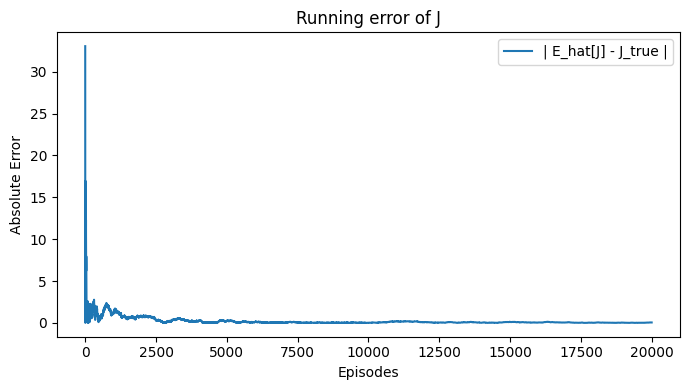

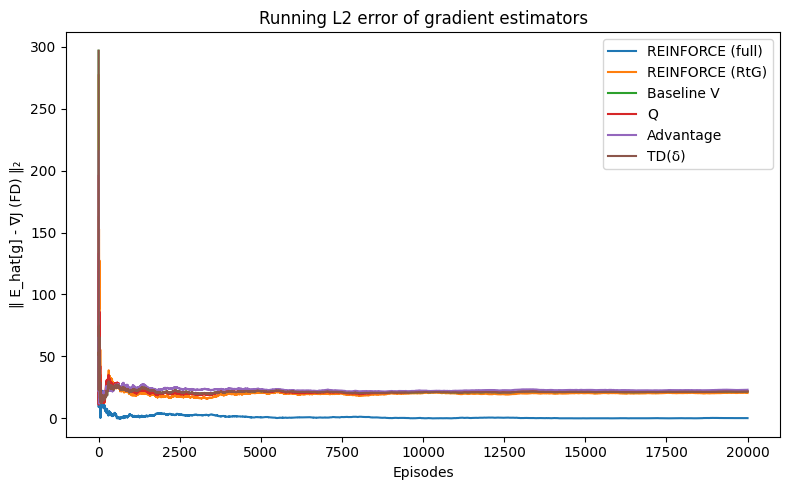

In [11]:
import math, random
from typing import Tuple, List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
from torch.func import functional_call, vmap, jacrev


# ----------------- utilities -----------------
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# ----------------- policy network (last layer Softmax) -----------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 2.1: Implement the policy network

    def __init__(self, hidden: int = 2):
        super().__init__()
        # input is scalar x = s/N
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2)      # logits for [L, R]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (B,) or (B,1). Ensure 2D.
        if x.dim() == 1:
            x = x.unsqueeze(1)
        logits = self.net(x)
        return F.softmax(logits, dim=-1)  # probabilities over {L, R}
    
    #########################################
    

# ----------------- DP: exact J(θ) using policy p_s -----------------
def build_system(model: PolicyNet, N: int, gamma: float,
                 running_reward: float, terminal_reward: float):
    """
    In tabular case, we could build A,b directly from the bellman's equations (eq 1.21 in lecture note).
    Build linear system A V = b for states s=1..N-1.
    Transition probabilities p_s come from the torch policy (Right prob).
    """
    model.eval()
    with torch.no_grad():
        s_idx = torch.arange(1, N, dtype=torch.float32)
        x = s_idx / float(N)                  # (N-1,)
        pi = model(x)                         # (N-1, 2)
        p = pi[:, 1].cpu().numpy()            # P(right | s)
        q = (1.0 - p)                         # P(left  | s)

    A = np.zeros((N-1, N-1), dtype=np.float64)
    b = np.zeros(N-1, dtype=np.float64)

    if N - 1 == 1:
        A[0, 0] = 1.0
        b[0] = terminal_reward
        return A, b

    # s = 1 (index 0)
    A[0, 0] = 1.0
    A[0, 1] = -gamma * p[0]
    b[0] = q[0] * terminal_reward + p[0] * running_reward

    # s = 2..N-2 (indices 1..N-3)
    for s in range(2, N-1):
        i = s - 1
        A[i, i]   = 1.0
        A[i, i-1] = -gamma * q[i]
        A[i, i+1] = -gamma * p[i]
        b[i]      = running_reward

    # s = N-1 (index N-2)
    i = N - 2
    A[i, i]   = 1.0
    A[i, i-1] = -gamma * q[i]
    b[i]      = p[i] * terminal_reward + q[i] * running_reward
    return A, b

def get_V_and_J(model: PolicyNet, N: int, gamma: float,
                running_reward: float, terminal_reward: float):
    """Solve A V = b; return V(s) for s=1..N-1 and uniform-start J."""
    A, b = build_system(model, N, gamma, running_reward, terminal_reward)
    V = np.linalg.solve(A, b)
    return V, float(V.mean())

def get_Q(model: PolicyNet, N: int, gamma: float,
          running_reward: float, terminal_reward: float):
    """
    Q(s,a) via one-step lookahead using V from DP.
    Returns Q for s=1..N-1 (shape (N-1, 2)).
    """
    V, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    V_full = np.zeros(N + 1)
    V_full[1:N] = V
    s = np.arange(1, N, dtype=np.int64)
    sL, sR = s - 1, s + 1
    rL = np.where(sL == 0, terminal_reward, running_reward)
    rR = np.where(sR == N, terminal_reward, running_reward)
    Q = np.empty((N-1, 2), dtype=np.float64)
    Q[:, 0] = rL + gamma * V_full[sL]
    Q[:, 1] = rR + gamma * V_full[sR]
    return Q

# ----------------- Finite-difference gradient on θ (torch) -----------------
def finite_difference_grad(model: PolicyNet, N: int, gamma: float,
                           running_reward: float, terminal_reward: float,
                           eps: float = 1e-4, relative: bool = False,
                           scheme: str = 'central'):
    """
    Finite-difference ∇θ J where θ is the concatenated torch parameter vector.
    Supports central or forward difference. Optional relative step size.
    """
    theta0 = parameters_to_vector(model.parameters()).detach().clone()
    _, J0 = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    grad = torch.zeros_like(theta0)

    for i in range(theta0.numel()):
        base = float(abs(theta0[i])) if relative else 1.0
        h = eps * max(1.0, base)

        if scheme.lower() == 'central':
            th_p = theta0.clone(); th_p[i] += h
            th_m = theta0.clone(); th_m[i] -= h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            vector_to_parameters(th_m, model.parameters())
            Jm = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - Jm) / (2.0 * h)
        elif scheme.lower() == 'forward':
            th_p = theta0.clone(); th_p[i] += h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - J0) / h
        else:
            raise ValueError("scheme must be 'central' or 'forward'")

    # restore original params
    vector_to_parameters(theta0, model.parameters())
    return J0, grad.detach()

# ----------------- MC gradient estimators (REINFORCE family) -----------------
def mc_grad_estimators(model: PolicyNet, N: int, s0_batch: torch.Tensor, gamma: float,
                       step_cost: float, terminal_reward: float,
                       V: torch.Tensor = None, Q: torch.Tensor = None):
    """
    We compute per-sample score vectors using autograd by calling backward()
    on log π(a_t|s_t) to obtain ∇θ log π(a_t|s_t).

    Returns (all numpy arrays):
      g1..g6: (B, P) per-episode gradient samples; J: (B,)
        g1: full-return REINFORCE
        g2: return-to-go REINFORCE (via cumulative scores H)
        g3: baseline with V(s_t)
        g4: use Q(s_t, a_t)
        g5: use Advantage A = Q − V
        g6: use TD residual δ_t = r_t + γ V(s_{t+1}) − V(s_t)
    """
    device = next(model.parameters()).device
    model.eval()
    
    names, base_params = zip(*list(model.named_parameters()))
    # Detach so these are leaf tensors, then turn grad on (required by jacrev)
    params = tuple(p.detach().requires_grad_(True) for p in base_params)
    P = sum(p.numel() for p in params)

    B = int(s0_batch.numel())
    s    = s0_batch.to(device).clone()
    done = (s == 0) | (s == N)

    H  = torch.zeros(B, P, device=device)  # cumulative score per-episode
    g1 = torch.zeros(B, P, device=device)
    g2 = torch.zeros(B, P, device=device)
    g3 = torch.zeros(B, P, device=device)
    g4 = torch.zeros(B, P, device=device)
    g5 = torch.zeros(B, P, device=device)
    g6 = torch.zeros(B, P, device=device)
    J  = torch.zeros(B,   device=device)
    gpw= torch.ones (B,   device=device)  # γ^t

    if V is not None:
        V = V.to(device)     # shape N+1, suggest V[0]=V[N]=0
    if Q is not None:
        Q = Q.to(device)     # shape (N+1,2), with Q(0,.)=Q(N,.)=0 if you padded
    
    def logp_single(param_tensors, s_scalar: torch.Tensor, a_scalar: torch.Tensor):
        # Build a param dict for functional_call
        pmap = {n: t for n, t in zip(names, param_tensors)}
        x = (s_scalar.float() / float(N)).view(1, 1)
        probs = functional_call(model, pmap, (x,))    # (1,2)
        # Differentiable action selection via gather (avoid data-dependent indexing pitfalls)
        logp = probs.log().gather(1, a_scalar.long().view(1, 1)).squeeze()  # scalar
        return logp

    # Note: you may found this function useful, this calculate ∇θ log π(a_i|s_i) in a batch manner
    def score_matrix_batch(active_s: torch.Tensor, active_a: torch.Tensor) -> torch.Tensor:
        """
        Returns (B_act, P) where each row is ∇θ log π(a_i|s_i),
        computed efficiently via vmap(jacrev) over (s,a).
        """
        # jac is a pytree of tensors matching param shapes, each with leading dim B_act
        jac = vmap(jacrev(logp_single), in_dims=(None, 0, 0))(params, active_s, active_a)
        # Flatten each param’s jacobian and concatenate along feature dim
        parts = [g.reshape(g.shape[0], -1) for g in jac]
        return torch.cat(parts, dim=1)  # (B_act, P)

    # Per-episode accumulators (shape notes in comments)
    S_sum = torch.zeros(B, P, device=device)   # ∑_t ∇θ log π(a_t|s_t) (for g1)
    base_acc = torch.zeros(B, P, device=device)  # ∑_t V(s_t) ∇θ log π(a_t|s_t) (for g3)

    while not torch.all(done):
        idx = (~done).nonzero(as_tuple=False).squeeze(1)
        if idx.numel() == 0:
            break

        # Sample actions for all active states in one forward pass
        x = (s[idx].float() / float(N)).unsqueeze(1)
        with torch.no_grad():
            probs = model(x)                            # (B_act, 2)
            a = torch.multinomial(probs, 1).squeeze(1) # (B_act,)

        # ∇θ log π(a|s): (B_act, P) using backward()
        score_mat = score_matrix_batch(s[idx], a)

        # Next state, termination, and rewards
        s_next   = s[idx] + torch.where(a == 1, 1, -1)
        term_any = (s_next == 0) | (s_next == N)
        r_t = torch.where(
            term_any,
            torch.tensor(terminal_reward, device=device),
            torch.tensor(step_cost, device=device)
        ).float()
        
        #########################################
        #TODO 2.1: Implement the six policy gradient estimators

        # 1) Update discounted score accumulator H (for return-to-go style estimators)
        H[idx] = gamma * H[idx] + score_mat

        # 2) J per-episode (discounted) and sum of scores (for g1)
        J[idx]   = J[idx] + gpw[idx] * r_t
        S_sum[idx] += score_mat
        gpw[idx] = gpw[idx] * gamma

        # 3) g2: return-to-go REINFORCE via identity  Σ_t r_t H_t  ==  Σ_t G_t ∇logπ_t
        g2[idx] += (r_t.unsqueeze(1) * H[idx])

        # 4) g3: baseline with V(s_t): g3 = Σ_t (G_t - V(s_t)) ∇logπ_t
        # Using the same identity, g3 = g2 - Σ_t V(s_t) ∇logπ_t
        if V is not None:
            v_s = V[s[idx]].unsqueeze(1)               # (B_act,1)
            base_acc[idx] += v_s * score_mat           # accumulate baseline term

        # 5) g4: use Q(s_t, a_t):  Σ_t Q(s_t,a_t) ∇logπ_t
        if Q is not None:
            q_sa = Q[s[idx], a]                        # (B_act,)
            g4[idx] += q_sa.unsqueeze(1) * score_mat

        # 6) g5: advantage A = Q − V:  Σ_t A(s_t,a_t) ∇logπ_t
            a_sa = q_sa - V[s[idx]]
            g5[idx] += a_sa.unsqueeze(1) * score_mat

        # 7) g6: TD residual δ_t with eligibility (H):  Σ_t δ_t H_t
        if V is not None:
            v_s      = V[s[idx]]
            v_s_next = V[s_next.clamp(min=0, max=N)]   # safety
            delta = r_t + gamma * v_s_next - v_s       # (B_act,)
            g6[idx] += delta.unsqueeze(1) * H[idx]

        # Step state & done flags
        s[idx] = s_next
        done[idx] = term_any

        # Finalize episodes that just terminated
        if term_any.any():
            fidx = idx[term_any]
            # g1: full-return REINFORCE: (total discounted return) * (sum of scores)
            g1[fidx] = J[fidx].unsqueeze(1) * S_sum[fidx]
            # g3: subtract accumulated baseline term (rest already in g2)
            if V is not None:
                g3[fidx] = g2[fidx] - base_acc[fidx]

        #########################################

        
    return (g1.detach().cpu().numpy(),
            g2.detach().cpu().numpy(),
            (g3.detach().cpu().numpy() if V is not None else np.zeros_like(g2.detach().cpu().numpy())),
            (g4.detach().cpu().numpy() if Q is not None else np.zeros_like(g2.detach().cpu().numpy())),
            (g5.detach().cpu().numpy() if (V is not None and Q is not None) else np.zeros_like(g2.detach().cpu().numpy())),
            g6.detach().cpu().numpy() if V is not None else np.zeros_like(g2.detach().cpu().numpy()),
            J.detach().cpu().numpy())

# ----------------- main -----------------
set_seed(0)
device = torch.device("cpu")

# Environment
N = 10
gamma = 0.9
running_reward = -1.0
terminal_reward = 100.0

# Policy
model = PolicyNet(hidden=2).to(device)

# Exact J and FD gradient
J_true, grad_fd = finite_difference_grad(
    model, N, gamma, running_reward, terminal_reward,
    eps=1e-4, relative=True, scheme='central'
)

# Baselines from DP value V(s) and Q(s,a)
V_np, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
V = torch.tensor(np.concatenate(([0.0], V_np, [0.0])), dtype=torch.float32, device=device)  # V(0)=V(N)=0

Q_np = get_Q(model, N, gamma, running_reward, terminal_reward).astype(np.float32)
Q_t  = torch.tensor(Q_np, dtype=torch.float32, device=device)
zero_row = torch.zeros(1, 2, dtype=torch.float32, device=device)
Q = torch.cat([zero_row, Q_t, zero_row], dim=0)  # Q(0,.)=Q(N,.)=0

# Monte Carlo (batched episodes)
episodes = 20000  # adjust as needed
s0_batch = torch.randint(1, N, (episodes,), dtype=torch.int64, device=device)
g1, g2, g3, g4, g5, g6, J = mc_grad_estimators(
    model, N, s0_batch, gamma,
    step_cost=running_reward,
    terminal_reward=terminal_reward,
    V=V, Q=Q
)

#########################################
#TODO 2.1: Plot your result here
# 1. Print out the standard deviation of each gradient estimator
# 2. Plot the running error of the estimated J vs the true J, you may found np.cumsum(:, axis=0) / np.arange(1, len(J) + 1) useful
# 3. Plot the running error of each gradient estimator vs the FD gradient

# Flatten helper: (B, P) -> per-parameter stds and a single summary
def per_param_std(G):
    return G.std(axis=0)  # (P,)
def mean_std(G):
    return float(G.std(axis=0).mean())
def normalized_mean_std(G):
    norms = np.linalg.norm(G, axis=1, keepdims=True)
    G_norm = G / (norms + 1e-8)
    return float(G_norm.std(axis=0).mean())

names = ["REINFORCE (full)", "REINFORCE (RtG)", "Baseline V", "Q", "Advantage", "TD(δ)"]
Gs = [g1, g2, g3, g4, g5, g6]

print("\nPer-estimator mean per-parameter std:")
for n, G in zip(names, Gs):
    print(f"  {n:16s}: {mean_std(G):.6f}")

print("\nPer-estimator normalized mean per-parameter std:")
for n, G in zip(names, Gs):
    print(f"  {n:16s}: {normalized_mean_std(G):.6f}")

# 2) Running error of J estimates
J_true_scalar = float(J_true)
J_running_mean = np.cumsum(J, axis=0) / np.arange(1, len(J) + 1)
J_running_mean = J_running_mean.squeeze()
J_err = np.abs(J_running_mean - J_true_scalar)

plt.figure(figsize=(7,4))
plt.plot(J_err, label="| E_hat[J] - J_true |")
plt.xlabel("Episodes")
plt.ylabel("Absolute Error")
plt.title("Running error of J")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Running L2 error of gradient means vs finite-difference grad
grad_true = grad_fd.detach().cpu().numpy().reshape(-1)  # (P,)

plt.figure(figsize=(8,5))
for n, G in zip(names, Gs):
    # Running mean of gradients: (k,P)
    G_cum = np.cumsum(G, axis=0)
    ks = np.arange(1, G.shape[0] + 1)[:, None]
    G_mean = G_cum / ks
    # L2 error per k
    err = np.linalg.norm(G_mean - grad_true, axis=1)
    J_running_mean = J_running_mean.squeeze()

    plt.plot(err, label=n)
plt.xlabel("Episodes")
plt.ylabel("‖ E_hat[g] - ∇J (FD) ‖₂")
plt.title("Running L2 error of gradient estimators")
plt.legend()
plt.tight_layout()
plt.show()
#########################################


---

The first plot shows how the Monte Carlo estimate of the expected return $J$ converges to the true value obtained via dynamic programming. Initially, the error is large because only a few episodes have been sampled, making the average return estimate noisy. As more trajectories are collected, the sample mean becomes a more accurate approximation of the true expectation due to the Law of Large Numbers. Consequently, the absolute error quickly drops toward zero and stabilizes, confirming that the Monte Carlo return estimator is unbiased and consistent.

The second plot compares six different policy gradient estimators against the finite-difference (true) gradient. All estimators start with large errors because the gradient estimates are noisy early on, but over time the running averages converge toward the true gradient. The plain REINFORCE estimator has the highest variance, since it multiplies the total return by the policy’s score, making it noisy but unbiased. Introducing baselines, or using Q-values, advantages, or TD-errors, keeps the expectation unchanged while significantly reducing variance. As a result, these modified estimators converge faster and more smoothly.

---

### 2.2 REINFORCE algorithm

**Algorithm Recap — REINFORCE (Monte-Carlo Policy Gradient)**

1. **Policy network**  
   Stochastic policy $\pi_\theta(a\mid s)$ 

2. **Trajectory sampling**  
   Roll out episodes with $\pi_\theta$: $(s_1,a_1,r_1,\dots,s_T,a_T,r_T)$.

3. **Returns / advantages**
   - Monte-Carlo return:
     $$
     G_t=\sum_{t'=t}^{T}\gamma^{\,t'-t} r_{t'}.
     $$
   - Advantage: $A_t = G_t - b(s_t)$.

4. **Policy-gradient update**
   - Estimator:
     $$
     \hat g(\theta)=\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T_i}
       \nabla_\theta \log \pi_\theta(a_t^{(i)}\mid s_t^{(i)})\, \gamma^t A_t^{(i)}.
     $$
   - Gradient ascent: $\theta \leftarrow \theta + \alpha\,\hat g(\theta)$.

5. **Learned value baseline (optional)**
   - Regress $V_\psi(s)$ to returns:
     $$
     \min_\psi \frac{1}{N}\sum_{i,t}\big(V_\psi(s_t^{(i)})-G_t^{(i)}\big)^2,
     \qquad A_t\!=\!G_t\!-\!V_\psi(s_t).
     $$

6. **Mini-batch training**
   - Collect $N$ episodes (or $M$ steps), compute $G_t/A_t$; optimize
     $$
     \mathcal{L}_{\text{PG}}(\theta)=
     -\frac{1}{N}\sum_{i,t}\log\pi_\theta(a_t^{(i)}\mid s_t^{(i)})\,A_t^{(i)}.
     $$

**TODO:**
- implement policy net and value net
- implement the main algorithm


In [14]:
import numpy as np
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 400
BATCH_SIZE = 16
MAX_EP_LEN = 1000
VALUE_UPDATES = 10

GRAD_CLIP = 10.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(False)

# ------------------- tensor wrapper (given as a reference) -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info
    
env = TWrapper(env)

# ------------------- discrete policy net (given as a reference) -------------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 2.2: Implement policy network

    def __init__(self, obs_dim: int, hidden: int, act_dim: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, act_dim)   # logits
        )
        # (optional) good init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)  # return logits (not softmax)
    
    #########################################
    
# ------------------- value baseline (given as a reference) -------------------
class ValueNet(nn.Module):
    #########################################
    #TODO 2.2: Implement value network

    def __init__(self, obs_dim: int, hidden: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x).squeeze(-1)  # (B,)

    #########################################
    
    
policy = PolicyNet(obs_dim=obs_dim, hidden=HIDDEN, act_dim=act_dim).to(DEVICE)
vnet   = ValueNet(obs_dim=obs_dim, hidden=HIDDEN).to(DEVICE)

# ------------------- utils -------------------
def mc_returns_single_traj(R: torch.Tensor, gamma: float) -> torch.Tensor:
    """R: [T] -> G: [T], reverse within a single trajectory."""
    G = torch.zeros_like(R)
    running = 0.0
    for t in range(R.numel() - 1, -1, -1):
        running = R[t] + gamma * running
        G[t] = running
    return G

# ------------------- training -------------------
def train():
    #########################################
    #TODO 2.2: Implement vanilla REINFORCE algorithm

    policy_opt = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
    value_opt  = torch.optim.Adam(vnet.parameters(),   lr=LR_VALUE)

    returns_history = []

    for epoch in range(1, MAX_EPOCHS + 1):
        # ---- Collect a batch of episodes ----
        batch_obs, batch_acts, batch_rewards, batch_T = [], [], [], []
        ep_returns = []
        while len(batch_T) < BATCH_SIZE:
            obs, _ = env.reset()
            obs = obs.to(DEVICE)  # (1,obs_dim)
            ep_obs, ep_acts, ep_rewards = [], [], []
            for t in range(MAX_EP_LEN):
                logits = policy(obs)                         # (1, act_dim)
                dist = Categorical(logits=logits)
                a = dist.sample()                            # (1,)
                next_obs, r, done, _ = env.step(a)          # tensors
                ep_obs.append(obs.squeeze(0))               # (obs_dim,)
                ep_acts.append(a.squeeze(0).long())         # ()
                ep_rewards.append(r.squeeze(0))             # ()
                obs = next_obs.to(DEVICE)
                if done.item():
                    break
            # pack one episode
            R = torch.stack(ep_rewards, dim=0).to(DEVICE).squeeze(-1)  # (T,)
            G = mc_returns_single_traj(R, GAMMA)                       # (T,)
            batch_obs.append(torch.stack(ep_obs,  dim=0))              # (T,obs)
            batch_acts.append(torch.stack(ep_acts, dim=0))             # (T,)
            batch_rewards.append(G)                                    # (T,)
            batch_T.append(len(ep_rewards))
            ep_returns.append(float(R.sum().item()))

        # ---- Flatten batch (keep per-step time index for γ^t) ----
        T_max = max(batch_T)
        # Concatenate
        O = torch.cat(batch_obs,  dim=0).to(DEVICE)              # (sumT, obs)
        A = torch.cat(batch_acts, dim=0).to(DEVICE)              # (sumT,)
        G_all = torch.cat(batch_rewards, dim=0).to(DEVICE)       # (sumT,)

        # Build per-step γ^t weights (compute t inside each episode)
        gammas = []
        for T in batch_T:
            t = torch.arange(T, device=DEVICE, dtype=torch.float32)
            gammas.append(GAMMA ** (t))
        gamma_pow = torch.cat(gammas, dim=0)                     # (sumT,)

        # ---- Baseline and advantages ----
        with torch.no_grad():
            V_pred = vnet(O)                                     # (sumT,)
        A_hat = G_all - V_pred                                   # (sumT,)
        # (optional) advantage normalization to reduce variance
        if A_hat.numel() > 1:
            A_hat = (A_hat - A_hat.mean()) / (A_hat.std() + 1e-8)

        # ---- Policy loss (maximize => minimize negative) ----
        logits = policy(O)
        logp = Categorical(logits=logits).log_prob(A)            # (sumT,)
        pg_loss = -(logp * (gamma_pow * A_hat.detach())).mean()

        policy_opt.zero_grad(set_to_none=True)
        pg_loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        policy_opt.step()

        # ---- Value regression to returns ----
        for _ in range(VALUE_UPDATES):
            v_pred = vnet(O)
            v_loss = F.mse_loss(v_pred, G_all)
            value_opt.zero_grad(set_to_none=True)
            v_loss.backward()
            nn.utils.clip_grad_norm_(vnet.parameters(), GRAD_CLIP)
            value_opt.step()

        # ---- Logging ----
        avg_ret = float(np.mean(ep_returns))
        returns_history.append(avg_ret)
        if epoch % 10 == 0:
            print(f"[Epoch {epoch:03d}] avg_return={avg_ret:7.2f}  "
                  f"pg_loss={pg_loss.item():.4f}  v_loss={v_loss.item():.4f}  "
                  f"batch_T={batch_T}")

    #########################################
    
    print("Training finished.")
    return policy, vnet, returns_history

policy, vnet, returns_history = train()

def eval(policy, episodes=10, greedy=True, device=DEVICE, max_len=MAX_EP_LEN):
    env = gym.make("Acrobot-v1")
    policy.eval()
    succ, max_hs = [], []
    with torch.no_grad():
        for _ in range(episodes):
            o, _ = env.reset()
            ok, m = False, -1e9
            for _ in range(max_len):
                s = torch.as_tensor(o, dtype=torch.float32, device=device).unsqueeze(0)
                logits = policy(s)
                a = int(logits.argmax(-1)) if greedy else int(Categorical(logits=logits).sample())
                o, r, term, trunc, _ = env.step(a)
                c1, s1, c2, s2 = o[:4]; m = max(m, float(-c1 - (c1*c2 - s1*s2)))  # tip height
                if term or trunc: ok = bool(term); break
            succ.append(ok); max_hs.append(m)
    print(f"success={np.mean(succ):.1%}, mean_max_tip={np.mean(max_hs):.3f}")
    
eval(policy, episodes=100, greedy=True)

[Epoch 010] avg_return=-243.50  pg_loss=-0.1590  v_loss=6560.1514  batch_T=[198, 305, 225, 332, 240, 197, 500, 278, 188, 203, 200, 240, 210, 176, 227, 192]
[Epoch 020] avg_return=-164.50  pg_loss=-0.1903  v_loss=2071.1672  batch_T=[176, 214, 267, 141, 141, 152, 105, 160, 143, 168, 190, 145, 163, 167, 121, 195]
[Epoch 030] avg_return=-133.19  pg_loss=-0.1089  v_loss=1142.1882  batch_T=[142, 111, 100, 91, 125, 129, 170, 105, 296, 119, 124, 126, 122, 145, 123, 119]
[Epoch 040] avg_return=-104.69  pg_loss=-0.1727  v_loss=231.1954  batch_T=[112, 77, 113, 84, 126, 89, 100, 98, 108, 88, 101, 119, 101, 136, 122, 117]
[Epoch 050] avg_return=-100.12  pg_loss=-0.1285  v_loss=187.8208  batch_T=[146, 108, 94, 85, 93, 94, 113, 87, 88, 105, 101, 93, 95, 130, 87, 99]
[Epoch 060] avg_return=-100.25  pg_loss=-0.0378  v_loss=219.9280  batch_T=[127, 113, 95, 102, 113, 105, 79, 166, 83, 98, 90, 89, 94, 97, 89, 80]
[Epoch 070] avg_return= -99.00  pg_loss=-0.0194  v_loss=238.8527  batch_T=[127, 81, 85, 100, 

## Problem 3: Actor-critic

REINFORCE with learned value function often have high variance (recall what we find in PSET2 2.1). Actor-critic method replace the advantage $A_t = G_t - b(s_t)$ with temporal-difference error $r_t + \gamma V(s_{t+1}) - V(s_t)$

**Algorithm recap**

1. **Networks**
   - **Actor**: stochastic policy $ \pi_\theta(a\mid s) $.
   - **Critic**: value $ V_\psi(s) $
  
2. **Data collection**
   
   Roll out for $n$ steps (or full episodes) with $\pi_\theta$; store $(s_t,a_t,r_t,s_{t+1},\text{done}_t)$.

3. **TD advantage (one-step)**
   $$
   y_t = r_t + \gamma \,V_{\psi}(s_{t+1}),\qquad
   \delta_t = y_t - V_\psi(s_t).
   $$
   Use $\delta_t$ as **advantage** (variance lower than Monte-Carlo $G_t$).

4. **Losses**
   - **Actor**  
     $$
     \mathcal L_{\pi}(\theta)
     = -\,\mathbb E\big[\,\log \pi_\theta(a_t\!\mid s_t)\,\delta_t \big]
     $$
   - **Critic**  
     $$
     \mathcal L_V(\psi) = \tfrac12\,\mathbb E\big[(V_\psi(s_t)-y_t)^2\big].
     $$

Several other features you may consider:
- Multi-step update for value function 
- Normalize the advantage over batch

**TODO:**
- implement policy net and value net
- implement the main algorithm

In [ ]:
# On-policy Actor–Critic for Acrobot-v1
# - Discrete actions, update every K steps (no need to finish episodes)

import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 500
STEPS_PER_UPDATE = 64           # ← collect this many steps, then update (true on-policy)

CRITIC_UPDATES = 1              # critic updates per actor step
GRAD_CLIP = 10.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
torch.use_deterministic_algorithms(False)

# ------------------- networks -------------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 3.1: Implement policy network
    def __init__(self, obs_dim: int, hidden: int, act_dim: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, act_dim)  # logits
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x)  # logits

    #########################################
    

class ValueNet(nn.Module):
    #########################################
    #TODO 3.1: Implement value network

    def __init__(self, obs_dim: int, hidden: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mlp(x).squeeze(-1)  # (B,)
    
    #########################################
    

policy = PolicyNet(obs_dim, HIDDEN, act_dim).to(DEVICE)
value  = ValueNet(obs_dim, HIDDEN).to(DEVICE)
opt_pi = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
opt_v  = torch.optim.Adam(value.parameters(),  lr=LR_VALUE)

# ------------------- helper -------------------
@torch.no_grad()
def to_t(s): return torch.as_tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)

# ------------------- training (A2C / 1-step actor-critic) -------------------
def train():
    returns_history: List[float] = []
    ep_ret, ep_len = 0.0, 0
    obs, _ = env.reset(seed=SEED)
    #########################################
    #TODO 3.1: Implement the main algorithm

    for epoch in range(1, MAX_EPOCHS + 1):
        # ----- collect on-policy batch of STEPS_PER_UPDATE transitions -----
        S, A, R, S2, D = [], [], [], [], []
        for _ in range(STEPS_PER_UPDATE):
            s_t = to_t(obs)                                # (1, obs_dim)
            with torch.no_grad():
                logits = policy(s_t)
                dist = Categorical(logits=logits)
                a_t = dist.sample()                        # (1,)

            obs_next, r, term, trunc, _ = env.step(int(a_t.item()))
            done = bool(term or trunc)

            # store transition
            S.append(torch.as_tensor(obs,      dtype=torch.float32, device=DEVICE))
            A.append(torch.as_tensor(a_t.item(), dtype=torch.long,   device=DEVICE))
            R.append(torch.as_tensor(r,        dtype=torch.float32, device=DEVICE))
            S2.append(torch.as_tensor(obs_next,dtype=torch.float32, device=DEVICE))
            D.append(torch.as_tensor(done,     dtype=torch.bool,    device=DEVICE))

            # episodic logging
            ep_ret += r
            ep_len += 1
            obs = obs_next
            if done:
                returns_history.append(ep_ret)
                ep_ret, ep_len = 0.0, 0
                obs, _ = env.reset()

        # ----- stack batch -----
        S   = torch.stack(S,  dim=0)  # (B, obs_dim)
        A   = torch.stack(A,  dim=0)  # (B,)
        R   = torch.stack(R,  dim=0)  # (B,)
        S2  = torch.stack(S2, dim=0)  # (B, obs_dim)
        D   = torch.stack(D,  dim=0)  # (B,)


- **Env**: `Pendulum-v1` (pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/pendulum/)
- **Observation**: 3-D vector $[\cos\theta,\ \sin\theta,\ \dot\theta]$.
- **Actions**: Continuous torque, shape $(1,)$, range $[-2, 2]$ (env clips to bounds).
- **Reward**: 
  $$ r = -\big(\theta^2 + 0.1\,\dot\theta^{\,2} + 0.001\,u^{2}\big) $$
  where $\theta\in(-\pi,\pi]$ is angle to upright ($0$ is upright), $\dot\theta$ is angular velocity, and $u$ is applied torque. Maximized when the pendulum is upright and still with minimal torque.


### Algorithm Recap

**Policy & Value.**
- Policy: Gaussian $\mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$.
- Critic: scalar value $V_\phi(s)$.

**Data collection (on-policy).**
- Roll out episodes using the current policy, storing $(s_t,a_t,r_t,s_{t+1},d_t)$.

**Targets and Advantage.**
        # ----- critic targets & TD advantage -----
        with torch.no_grad():
            v_s2 = value(S2)                                # (B,)
            y    = R + GAMMA * (~D).float() * v_s2          # bootstrap if not done
        v_s = value(S)                                      # (B,)
        delta = (y - v_s).detach()                          # advantage for actor

        # (optional) normalize advantage for variance reduction
        if delta.numel() > 1:
            delta = (delta - delta.mean()) / (delta.std() + 1e-8)

        # ----- actor loss (maximize => minimize negative) -----
        logits = policy(S)
        logp   = Categorical(logits=logits).log_prob(A)     # (B,)
        loss_pi = -(logp * delta).mean()

        opt_pi.zero_grad(set_to_none=True)
        loss_pi.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        opt_pi.step()

        # ----- critic loss (MSE to TD target), possibly multiple steps -----
        for _ in range(CRITIC_UPDATES):
            v_pred = value(S)
            loss_v = 0.5 * F.mse_loss(v_pred, y)
            opt_v.zero_grad(set_to_none=True)
            loss_v.backward()
            nn.utils.clip_grad_norm_(value.parameters(), GRAD_CLIP)
            opt_v.step()

        # simple logging
        if epoch % 10 == 0 and len(returns_history) > 0:
            avg_ret = float(np.mean(returns_history[-10:]))
            print(f"[Epoch {epoch:03d}] avg_return(10)={avg_ret:7.2f}  "
                  f"actor_loss={loss_pi.item():.4f}  critic_loss={loss_v.item():.4f}")
    #########################################
    
    print("Training finished.")
    return policy, value, returns_history

policy, value, returns = train()


[Epoch 010] avg_return(10)=-500.00  actor_loss=0.0053  critic_loss=0.4998
[Epoch 020] avg_return(10)=-406.00  actor_loss=0.0026  critic_loss=0.4771
[Epoch 030] avg_return(10)=-409.50  actor_loss=-0.0388  critic_loss=0.6619
[Epoch 040] avg_return(10)=-364.14  actor_loss=0.0755  critic_loss=1.9107
[Epoch 050] avg_return(10)=-349.00  actor_loss=0.0040  critic_loss=0.7666
[Epoch 060] avg_return(10)=-275.10  actor_loss=-0.1581  critic_loss=5.0311
[Epoch 070] avg_return(10)=-273.60  actor_loss=-0.1050  critic_loss=1.2743
[Epoch 080] avg_return(10)=-229.00  actor_loss=-0.1685  critic_loss=7.1851
[Epoch 090] avg_return(10)=-199.50  actor_loss=-0.1227  critic_loss=3.5918
[Epoch 100] avg_return(10)=-134.60  actor_loss=-0.0563  critic_loss=5.8739
[Epoch 110] avg_return(10)=-130.60  actor_loss=0.0055  critic_loss=0.6766
[Epoch 120] avg_return(10)=-128.20  actor_loss=-0.0255  critic_loss=2.6548
[Epoch 130] avg_return(10)=-120.00  actor_loss=0.0005  critic_loss=7.1494
[Epoch 140] avg_return(10)=-111

## Problem 4: PPO for pendulum

Vanilla actor-critic often face the problem of distribution shift. Advanced actor-critic deal with this problem by adding trust region constraints. PPO is the most famous and widely-used one in robotics. In this problem you will implement PPO on gym's `pendulum-v1` environment.

### Environment & action space

- **Env**: `Pendulum-v1` (pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/pendulum/)
- **Observation**: 3-D vector $[\cos\theta,\ \sin\theta,\ \dot\theta]$.
- **Actions**: Continuous torque, shape $(1,)$, range $[-2, 2]$ (env clips to bounds).
- **Reward**: 
  $$ r = -\big(\theta^2 + 0.1\,\dot\theta^{\,2} + 0.001\,u^{2}\big) $$
  where $\theta\in(-\pi,\pi]$ is angle to upright ($0$ is upright), $\dot\theta$ is angular velocity, and $u$ is applied torque. Maximized when the pendulum is upright and still with minimal torque.


### Algorithm Recap

**Policy & Value.**
- Policy: Gaussian $\mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$.
- Critic: scalar value $V_\phi(s)$.

**Data collection (on-policy).**
- Roll out episodes using the current policy, storing $(s_t,a_t,r_t,s_{t+1},d_t)$.

**Targets and Advantage.**
- One-step TD target: $\hat{V}_t = r_t + \gamma V_\phi(s_{t+1})$.
- TD residual: $\delta_t = \hat{V}_t - V_\phi(s_t)$.
- GAE($\lambda$) advantage:
  $$
  \hat{A}_t = \sum_{k=0}^{\infty} (\gamma\lambda)^k \, \delta_{t+k}.
  $$
  (Computed by a backward recursion.)

**PPO-Clip objective.**
- Log-ratio $r_t(\theta) = \frac{\pi_\theta(a_t\mid s_t)}{\pi_{\theta_{\text{old}}}(a_t\mid s_t)}$.
- Clipped surrogate:
  $$
  \mathcal{L}^{\text{CLIP}}(\theta)
  = \mathbb{E}\Big[\min\big(r_t(\theta)\hat{A}_t,\ \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t\big)\Big].
  $$
- Value loss: $\mathcal{L}_V = \|V_\phi(s_t) - \hat{V}_t\|_2^2$.
- Total loss (per minibatch): $-\mathcal{L}^{\text{CLIP}} + c_v \mathcal{L}_V$ (entropy term optional).

**Update.**
- Cache old log-probs once per batch.
- For several **epochs**, shuffle the batch and optimize the total loss on minibatches (Adam).

**TODO:** Implement a complete PPO agent from scratch, using the provided scaffold and suggested hyperparameters as a starting point.


In [20]:
from tqdm import tqdm
import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Pendulum-v1"
SEED = 0

LR_POLICY = 1e-4
# LR_VALUE  = 5e-3
LR_VALUE  = 1e-3
NUM_EPSIODE = 3000       # (kept your variable name)
HIDDEN = 128
GAMMA = 0.99
LAMBDA = 0.9
VF_COEF = 0.9            # value loss weight in the total loss
UPDATE_EPOCHS = 10       # PPO epochs per update
# CLIP_EPS = 0.2           # PPO clipping epsilon
CLIP_EPS = 0.1 
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

state_dim  = env.observation_space.shape[0]   # 3 for Pendulum
action_dim = env.action_space.shape[0]        # 1 for Pendulum

#########################################
#TODO 4: Implement PPO

class PolicyNetContinuous(nn.Module):
    def __init__(self, state_dim: int, hidden: int, action_dim: int):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden),    nn.Tanh(),
        )
        self.mu_head      = nn.Linear(hidden, action_dim)
        self.logstd_head  = nn.Linear(hidden, action_dim)
        # init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, s: torch.Tensor):
        h = self.backbone(s)
        mu = self.mu_head(h)                    # unbounded mean
        log_std = self.logstd_head(h).clamp(-5, 2)  # keep std in a sane range
        std = log_std.exp()
        return mu, std, log_std


class ValueNet(nn.Module):
    def __init__(self, state_dim: int, hidden: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden),    nn.Tanh(),
            nn.Linear(hidden, 1)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        return self.mlp(s).squeeze(-1)  # (B,)

#########################################

# ------------------- utils -------------------
def compute_advantage(gamma: float, lmbda: float, td_delta: torch.Tensor) -> torch.Tensor:
    """
    Pure torch GAE-style backward recursion to avoid NumPy conversions.
    td_delta: [T,1] or [T]; returns [T,1].
    """
    td = td_delta.view(-1)                # [T]
    adv = torch.zeros_like(td)
    gae = torch.zeros(1, dtype=td.dtype, device=td.device)
    for t in range(td.shape[0] - 1, -1, -1):
        gae = gamma * lmbda * gae + td[t]
        adv[t] = gae
    return adv.view(-1, 1)

# ------------------- PPO (continuous) -------------------
MAX_ACTION = float(env.action_space.high[0])  # 2.0 for Pendulum

ATANH_EPS = 1e-6

def atanh(x: torch.Tensor) -> torch.Tensor:
    # numerically safe inverse tanh
    x = x.clamp(-1 + ATANH_EPS, 1 - ATANH_EPS)
    return 0.5 * (torch.log1p(x) - torch.log1p(-x))

class PPOContinuous:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, vf_coef, gamma, device):
        self.actor  = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer  = torch.optim.Adam(self.actor.parameters(),  lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma  = gamma
        self.lmbda  = lmbda
        self.epochs = epochs
        self.eps    = eps
        self.vf_coef = vf_coef
        self.device = device


    @torch.no_grad()
    def act(self, s_np: np.ndarray):
        s = torch.as_tensor(s_np, dtype=torch.float32, device=self.device).unsqueeze(0)  # (1,S)
        mu, std, log_std = self.actor(s)                 # (1,A)
        # sample in pre-squash space
        u = torch.distributions.Normal(mu, std).rsample()    # (1,A)
        a = torch.tanh(u) * MAX_ACTION                        # env action in [-2,2]

        # log-prob with tanh correction
        base = torch.distributions.Normal(mu, std)
        logp_u = base.log_prob(u).sum(dim=-1)                 # (1,)
        # Jacobian term: sum log(1 - tanh(u)^2)
        log_det = torch.log(1 - torch.tanh(u).pow(2) + 1e-6).sum(dim=-1)
        logp = (logp_u - log_det).squeeze(0)                  # scalar tensor

        v = self.critic(s).squeeze(0)                         # scalar tensor
        return a.squeeze(0).cpu().numpy(), float(logp.item()), float(v.item())


    def evaluate(self, s: torch.Tensor, a: torch.Tensor):
        """
        s: (B,S), a: (B,A) actions actually sent to env in [-MAX_ACTION, MAX_ACTION].
        We unsquash actions back to pre-tanh u, then compute corrected log-prob.
        """
        mu, std, log_std = self.actor(s)                      # (B,A)
        # unsquash: a = tanh(u) * MAX_ACTION  =>  u = atanh(a/MAX_ACTION)
        a_scaled = (a / MAX_ACTION).clamp(-1 + ATANH_EPS, 1 - ATANH_EPS)
        u = atanh(a_scaled)

        base = torch.distributions.Normal(mu, std)
        logp_u = base.log_prob(u).sum(dim=-1)                 # (B,)
        log_det = torch.log(1 - torch.tanh(u).pow(2) + 1e-6).sum(dim=-1)
        logp = logp_u - log_det                               # (B,)

        # entropy: normal entropy is fine for a bonus or logging (no correction needed)
        entropy = (0.5 + 0.5 * math.log(2 * math.pi)) + log_std
        entropy = entropy.sum(dim=-1)                         # (B,)

        v = self.critic(s)                                    # (B,)
        return logp, entropy, v

# ------------------- training loop (Gymnasium API) -------------------
def train_on_policy_agent(env, agent: PPOContinuous, num_episodes):
    rng = np.random.default_rng(SEED)
    returns = []
    obs, _ = env.reset(seed=SEED)

    # minibatch size for PPO updates
    MINIBATCH_SIZE = 256

    for ep in tqdm(range(1, num_episodes + 1)):
        # ---- Collect one full on-policy trajectory ----
        traj_s, traj_a, traj_r, traj_s2, traj_d, traj_logp = [], [], [], [], [], []
        ep_ret = 0.0
        done = False
        steps = 0

        while not done:
            a, logp, v = agent.act(obs)
            next_obs, r, term, trunc, _ = env.step(a)
            done = bool(term or trunc)

            traj_s.append(obs.astype(np.float32))
            traj_a.append(a.astype(np.float32))
            traj_r.append(np.array([r], dtype=np.float32))
            traj_s2.append(next_obs.astype(np.float32))
            traj_d.append(np.array([done], dtype=np.bool_))
            traj_logp.append(np.array([logp], dtype=np.float32))

            obs = next_obs
            ep_ret += r
            steps += 1

            # optionally cap episode length if needed (Pendulum-v1 default is 200)
            # if steps >= 200: done = True

        returns.append(ep_ret)
        # reset env for next episode
        obs, _ = env.reset()

        # ---- Convert to tensors ----
        S   = torch.as_tensor(np.vstack(traj_s),   dtype=torch.float32, device=agent.device)  # (T,S)
        A   = torch.as_tensor(np.vstack(traj_a),   dtype=torch.float32, device=agent.device)  # (T,A)
        R   = torch.as_tensor(np.vstack(traj_r),   dtype=torch.float32, device=agent.device)  # (T,1)
        S2  = torch.as_tensor(np.vstack(traj_s2),  dtype=torch.float32, device=agent.device)  # (T,S)
        D   = torch.as_tensor(np.vstack(traj_d),   dtype=torch.bool,    device=agent.device)  # (T,1)
        LP0 = torch.as_tensor(np.vstack(traj_logp),dtype=torch.float32, device=agent.device).squeeze(-1)  # (T,)

        # ---- TD target and GAE(λ) advantage ----
        with torch.no_grad():
            v_s  = agent.critic(S)                   # (T,)
            v_s2 = agent.critic(S2)                  # (T,)
            y    = R.squeeze(-1) + agent.gamma * (~D.squeeze(-1)).float() * v_s2  # (T,)
            td   = y - v_s                           # (T,)
            adv  = compute_advantage(agent.gamma, agent.lmbda, td)   # (T,1)
            adv  = adv.squeeze(-1)
            # normalize advantage for stability
            adv = (adv - adv.mean()) / (adv.std() + 1e-8)
            # bootstrap-free value target for regression
            v_target = adv + v_s                     # (T,)

        # ---- PPO update over several epochs with minibatches ----
        T = S.shape[0]
        idx_all = np.arange(T)

        for _ in range(agent.epochs):
            rng.shuffle(idx_all)
            for start in range(0, T, MINIBATCH_SIZE):
                idx = idx_all[start:start + MINIBATCH_SIZE]
                s_mb   = S[idx]
                a_mb   = A[idx]
                adv_mb = adv[idx]
                v_tgt  = v_target[idx]
                lp0_mb = LP0[idx]

                logp, entropy, v_pred = agent.evaluate(s_mb, a_mb)  # (B,), (B,), (B,)

                ratio = torch.exp(logp - lp0_mb)                    # (B,)
                surr1 = ratio * adv_mb
                surr2 = torch.clamp(ratio, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS) * adv_mb
                policy_loss = -(torch.min(surr1, surr2)).mean()

                value_loss  = F.mse_loss(v_pred, v_tgt)
                total_loss  = policy_loss + agent.vf_coef * value_loss
                # (optional) add entropy bonus, e.g., -0.0 * entropy.mean()

                agent.actor_optimizer.zero_grad(set_to_none=True)
                agent.critic_optimizer.zero_grad(set_to_none=True)
                total_loss.backward()
                nn.utils.clip_grad_norm_(agent.actor.parameters(),  0.5)
                nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
                agent.actor_optimizer.step()
                agent.critic_optimizer.step()

        # simple logging
        if ep % 50 == 0:
            avg = float(np.mean(returns[-50:]))
            print(f"[Ep {ep:04d}] return(avg50) = {avg:8.2f}")

    return returns    

# ------------------- run -------------------
agent = PPOContinuous(state_dim, HIDDEN, action_dim, LR_POLICY, LR_VALUE,
                      LAMBDA, UPDATE_EPOCHS, CLIP_EPS, VF_COEF, GAMMA, DEVICE)
return_list = train_on_policy_agent(env, agent, NUM_EPSIODE)


  2%|▏         | 50/3000 [00:10<10:29,  4.69it/s]

[Ep 0050] return(avg50) = -1177.82


  3%|▎         | 100/3000 [00:21<10:17,  4.70it/s]

[Ep 0100] return(avg50) = -1236.21


  5%|▌         | 150/3000 [00:32<10:27,  4.54it/s]

[Ep 0150] return(avg50) = -1116.15


  7%|▋         | 200/3000 [00:43<10:06,  4.62it/s]

[Ep 0200] return(avg50) = -1056.27


  8%|▊         | 250/3000 [00:54<09:49,  4.66it/s]

[Ep 0250] return(avg50) = -1028.17


 10%|█         | 300/3000 [01:04<09:47,  4.60it/s]

[Ep 0300] return(avg50) = -1035.59


 12%|█▏        | 350/3000 [01:15<09:25,  4.69it/s]

[Ep 0350] return(avg50) = -1057.56


 13%|█▎        | 400/3000 [01:26<09:18,  4.65it/s]

[Ep 0400] return(avg50) = -1017.53


 15%|█▌        | 450/3000 [01:37<09:24,  4.51it/s]

[Ep 0450] return(avg50) =  -940.97


 17%|█▋        | 500/3000 [01:48<09:06,  4.58it/s]

[Ep 0500] return(avg50) =  -951.96


 18%|█▊        | 550/3000 [01:59<08:54,  4.58it/s]

[Ep 0550] return(avg50) =  -971.18


 20%|██        | 600/3000 [02:10<08:22,  4.78it/s]

[Ep 0600] return(avg50) = -1000.31


 22%|██▏       | 650/3000 [02:20<08:22,  4.68it/s]

[Ep 0650] return(avg50) =  -935.39


 23%|██▎       | 700/3000 [02:31<08:46,  4.37it/s]

[Ep 0700] return(avg50) =  -962.09


 25%|██▌       | 750/3000 [02:42<08:14,  4.55it/s]

[Ep 0750] return(avg50) =  -943.30


 27%|██▋       | 800/3000 [02:53<08:09,  4.50it/s]

[Ep 0800] return(avg50) =  -946.57


 28%|██▊       | 850/3000 [03:04<07:42,  4.65it/s]

[Ep 0850] return(avg50) =  -949.57


 30%|███       | 900/3000 [03:14<07:29,  4.68it/s]

[Ep 0900] return(avg50) =  -907.98


 32%|███▏      | 950/3000 [03:25<07:36,  4.49it/s]

[Ep 0950] return(avg50) =  -930.06


 33%|███▎      | 1000/3000 [03:36<07:20,  4.54it/s]

[Ep 1000] return(avg50) =  -962.19


 35%|███▌      | 1050/3000 [03:47<07:07,  4.56it/s]

[Ep 1050] return(avg50) =  -989.66


 37%|███▋      | 1100/3000 [03:58<06:50,  4.62it/s]

[Ep 1100] return(avg50) =  -947.32


 38%|███▊      | 1150/3000 [04:09<06:49,  4.52it/s]

[Ep 1150] return(avg50) =  -901.32


 40%|████      | 1200/3000 [04:20<06:30,  4.61it/s]

[Ep 1200] return(avg50) = -1047.55


 42%|████▏     | 1250/3000 [04:30<06:28,  4.51it/s]

[Ep 1250] return(avg50) =  -940.27


 43%|████▎     | 1300/3000 [04:41<06:15,  4.53it/s]

[Ep 1300] return(avg50) =  -970.04


 45%|████▌     | 1350/3000 [04:52<05:55,  4.64it/s]

[Ep 1350] return(avg50) =  -897.84


 47%|████▋     | 1400/3000 [05:03<05:53,  4.52it/s]

[Ep 1400] return(avg50) =  -903.60


 48%|████▊     | 1450/3000 [05:14<05:38,  4.58it/s]

[Ep 1450] return(avg50) =  -929.93


 50%|█████     | 1500/3000 [05:25<05:25,  4.61it/s]

[Ep 1500] return(avg50) =  -993.58


 52%|█████▏    | 1550/3000 [05:35<05:08,  4.70it/s]

[Ep 1550] return(avg50) =  -965.09


 53%|█████▎    | 1600/3000 [05:46<05:05,  4.58it/s]

[Ep 1600] return(avg50) =  -961.52


 55%|█████▌    | 1650/3000 [05:57<04:54,  4.58it/s]

[Ep 1650] return(avg50) = -1026.15


 57%|█████▋    | 1700/3000 [06:08<04:38,  4.67it/s]

[Ep 1700] return(avg50) =  -984.81


 58%|█████▊    | 1750/3000 [06:19<04:24,  4.73it/s]

[Ep 1750] return(avg50) = -1013.41


 60%|██████    | 1800/3000 [06:30<04:08,  4.82it/s]

[Ep 1800] return(avg50) =  -979.29


 62%|██████▏   | 1850/3000 [06:41<04:06,  4.66it/s]

[Ep 1850] return(avg50) =  -952.50


 63%|██████▎   | 1900/3000 [06:51<03:54,  4.68it/s]

[Ep 1900] return(avg50) =  -972.81


 65%|██████▌   | 1950/3000 [07:02<03:44,  4.68it/s]

[Ep 1950] return(avg50) =  -965.08


 67%|██████▋   | 2000/3000 [07:13<03:33,  4.67it/s]

[Ep 2000] return(avg50) =  -999.86


 68%|██████▊   | 2050/3000 [07:24<03:24,  4.64it/s]

[Ep 2050] return(avg50) = -1011.86


 70%|███████   | 2100/3000 [07:34<03:23,  4.43it/s]

[Ep 2100] return(avg50) =  -961.73


 72%|███████▏  | 2150/3000 [07:45<03:05,  4.59it/s]

[Ep 2150] return(avg50) =  -996.00


 73%|███████▎  | 2200/3000 [07:56<02:54,  4.58it/s]

[Ep 2200] return(avg50) = -1068.46


 75%|███████▌  | 2250/3000 [08:07<02:53,  4.31it/s]

[Ep 2250] return(avg50) = -1012.17


 77%|███████▋  | 2300/3000 [08:18<02:31,  4.61it/s]

[Ep 2300] return(avg50) = -1045.72


 78%|███████▊  | 2350/3000 [08:29<02:21,  4.60it/s]

[Ep 2350] return(avg50) =  -997.42


 80%|████████  | 2400/3000 [08:40<02:12,  4.53it/s]

[Ep 2400] return(avg50) = -1079.63


 82%|████████▏ | 2450/3000 [08:51<01:59,  4.62it/s]

[Ep 2450] return(avg50) = -1023.60


 83%|████████▎ | 2500/3000 [09:01<01:50,  4.52it/s]

[Ep 2500] return(avg50) = -1029.22


 85%|████████▌ | 2550/3000 [09:12<01:38,  4.58it/s]

[Ep 2550] return(avg50) = -1036.61


 87%|████████▋ | 2600/3000 [09:23<01:26,  4.63it/s]

[Ep 2600] return(avg50) =  -980.89


 88%|████████▊ | 2650/3000 [09:34<01:13,  4.76it/s]

[Ep 2650] return(avg50) = -1096.72


 90%|█████████ | 2700/3000 [09:45<01:04,  4.62it/s]

[Ep 2700] return(avg50) = -1017.51


 92%|█████████▏| 2750/3000 [09:56<00:54,  4.56it/s]

[Ep 2750] return(avg50) =  -986.22


 93%|█████████▎| 2800/3000 [10:07<00:42,  4.67it/s]

[Ep 2800] return(avg50) =  -933.95


 95%|█████████▌| 2850/3000 [10:18<00:31,  4.71it/s]

[Ep 2850] return(avg50) = -1043.14


 97%|█████████▋| 2900/3000 [10:29<00:21,  4.65it/s]

[Ep 2900] return(avg50) =  -994.02


 98%|█████████▊| 2950/3000 [10:39<00:10,  4.57it/s]

[Ep 2950] return(avg50) =  -989.68


100%|██████████| 3000/3000 [10:50<00:00,  4.61it/s]

[Ep 3000] return(avg50) = -1006.85


## Problem 5: Mujoco Half-cheetch envornment with stable baseline3

In this problem you will use gym's [Mujoco](https://gymnasium.farama.org/environments/mujoco/) environment and [stable baseline3](https://stable-baselines3.readthedocs.io/en/master/) to train a PPO network on Half-cheetah environment.

### Half-cheetah
This environment is based on the work of P. Wawrzyński in “A Cat-Like Robot Real-Time Learning to Run”. The HalfCheetah is a 2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws). The goal is to apply torque to the joints to make the cheetah run forward (right) as fast as possible, with a positive reward based on the distance moved forward and a negative reward for moving backward. 

Download it using `pip install "gymnasium[mujoco]"`

### Stable baseline 3
Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. You can directly load `PPO` module from the repo and define the hyper-parameter yourselves.

Download it using `pip install 'stable-baselines3[extra]'`

**TODO:** Tune the parameter yourself, what's your feeling about different parameters?

Note: the output is printed in the `logs/progress.csv` file.


In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

env = Monitor(gym.make("HalfCheetah-v4"))

#########################################
#TODO 5: Change the parameter yourself to finish training
#########################################

model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(
        log_std_init=-2,
        ortho_init=False,
        activation_fn=nn.ReLU,
        net_arch=dict(pi=[256, 256], vf=[256, 256]),
    ),
    # PPO clipping parameter
    clip_range=0.2,
    # entropy coefficient
    ent_coef=0.0004,
    # GAE lambda parameter
    gae_lambda=0.92,
    gamma=0.98,
    learning_rate=2.5e-5,
    max_grad_norm=0.8,
    n_steps=int(512*4),
    # number of epochs when optimizing one batch
    n_epochs=20,
    device="cpu",
    # value function coefficient in the loss
    vf_coef=0.5,
    verbose=1,
    seed=42
)

new_logger = configure("logs", ["csv"])
model.set_logger(new_logger)

n_envs = model.n_envs     
n_steps = model.n_steps   
total_ts = 500 * n_steps * n_envs

print("Starting learning...")
# This can take around 10 minutes on a Mac laptop
model.learn(total_ts, log_interval=10)
print("Learning finished.")
model.save(save)


/home/mj-seas/miniconda3/envs/ocrl_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Using cpu device
Wrapping the env in a DummyVecEnv.
Starting learning...
Learning finished.


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

# Load and test saved model
import time
env = gym.make("HalfCheetah-v4", render_mode="human")
env.reset()
# env = gym.make("racetrack-fast-v0", render_mode="rgb_array")
model = PPO.load(save, device="cpu")

while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    # time.sleep(0.1)
  env.render()

# import imageio

# frames = []
# obs, info = env.reset()
# done = truncated = False
# while not (done or truncated):
#     action, _ = model.predict(obs, deterministic=True)
#     obs, reward, done, truncated, info = env.step(action)
#     frames.append(env.render())  # returns RGB array

# # Save video
# imageio.mimsave("half_cheetah_run.gif", frames, fps=30)

: 